In [ ]:
import sys
sys.path.insert(1, r"/vol/bitbucket/mjh24/IAEA-thesis")
import os
os.environ.setdefault("HF_HOME", "/data/mjh24/hf")
os.environ.setdefault("TRANSFORMERS_CACHE", "/data/mjh24/hf/transformers")
os.makedirs(os.environ["TRANSFORMERS_CACHE"], exist_ok=True)
from Stage1.GAT.GATModel import GraphAttentionNetwork
from Single_Website_Download.Download import main as downloadHTML
import torch
from Stage1.ExtractingGraphs.seleniumDriver import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import *
from Stage2.txtGraphExtraction.extract_mini_txt_graphs_helper import main as txtExtractor
from Stage1.tree_helpers import *
from Stage2.txtGraphPruning.display_txt_graph import draw_graph_from_arrays
from Stage2.txtGraphPruning.prune_txt_graph import main as prune_txt_graph
from Stage2.classifyingEdges.classifyingTextNodes import clean_instructional_text
from Stage2.classifyingEdges.classifyingAnEdgeFLANT5 import classify_link_pairs_zero_shot
from pathlib import Path
import numpy as np

CLIP_TO_N_EDGES_PER_NODE = 10 # This is to clip all the outgoing edges per node to a certain number
device = device or ("cuda" if torch.cuda.is_available() else "cpu")
REMOVE_DUPES = False

/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/vol/bitbucket/mjh24/IAEA-thesis/.venv/lib/python3.12/site-packages/transformers/utils/hub.py:111: FutureWarning: Using `TRANSFORMERS_CACHE` is deprecated and will be removed in v5 of Transformers. Use `HF_HOME` instead.
  warnings.warn(


In [2]:
# Load model
model = GraphAttentionNetwork(in_dim = 119, edge_in_dim = 210, edge_emb_dim = 32, hidden1 = 32, hidden2 = 32, hidden3 = 8, heads = 2)
state_dict = torch.load("/vol/bitbucket/mjh24/IAEA-thesis/Stage1/GAT/LONG80EPOCH-75f1-newlabelnotitle.pt", map_location=torch.device(device))
model.load_state_dict(state_dict, strict=False)
model.to(device)

# Load the website
# url = "/vol/bitbucket/mjh24/IAEA-thesis/data/swde/sourceCode/sourceCode/movie/movie/movie-allmovie(2000)/0000.htm"
# url = r"https://www.nucnet.org/news/parliament-resolution-paves-way-for-establishing-nuclear-energy-legislation-6-4-2024"
url = "https://westinghousenuclear.com/"
# url = "https://www.football.co.uk/news/leeds-vs-bournemouth-premier-league-team-news-lineups-prediction/781112/"
# url = r"https://www.bbc.co.uk/news/live/cev28rvzlv1t"
# url = "https://www.nfl.com/teams/" # Great to show teams and structured data
# url = "https://www.energy.gov/ne/articles/advantages-and-challenges-nuclear-energy" #Great to show semi structured webpages with titles
# url = "https://westinghousenuclear.com/nuclear-fuel/fuel-fabrication-operations/"
# url = "https://www.livescore.com/en/football/england/premier-league/bournemouth-vs-leicester-city/1250940/lineups/"
htmlFile = Path("/vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html")
downloadHTML(url,1,htmlFile)

Saved https://westinghousenuclear.com/ → /vol/bitbucket/mjh24/IAEA-thesis/data/websites/test.html
Page limit hit


In [3]:
# Get label edges from text nodes in the website
sorted_label_index_extracted, xpaths_extracted, txts_extracted, probs_extracted = txtExtractor(htmlFile, model, remove_dupes=REMOVE_DUPES)
model.to("cpu")         # offload to CPU
if torch.cuda.is_available():
    torch.cuda.empty_cache() # reclaim GPU cache

/vol/bitbucket/mjh24/IAEA-thesis/Stage2/txtGraphExtraction/extract_mini_txt_graphs_helper.py:141: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:53.)
  return torch.sparse_csr_tensor(


In [4]:
# Normalise the text
normtxt = []
for a, b in txts_extracted:
    normtxt.append([normalise_text(a, "%'\\s"), normalise_text(b, "%'\\s")])
txts, probs, sorted_label_index, xpaths = np.array(normtxt), np.array(probs_extracted), np.array(sorted_label_index_extracted), np.array(xpaths_extracted)

In [5]:
# Remove all html instructional labels
txtsShortened = [[a.split(".")[0], b.split(".")[0]] for a, b in txts]
isInstruction, instructionalTxt = clean_instructional_text(txtsShortened, batch_size=32)
opmask = np.array(isInstruction, dtype=bool)
mask = np.logical_not(opmask)

for key, value in instructionalTxt.items():
    if value == 1:
        print(key)

learn more
france french
explore careers
take a look
explore our interactive 3d visualization tool for innovative answers to operating plant challenges
join our team
read more
explore
x click on the background to close the video
learn more about why databricks selected westinghouse ai for its 2025 data intelligence in energy utility award
blog
learn more about how westinghouse enhances training staffing and outsourcing with options that benefit your plants bottom line
learn more watch video
access our custom technology library designed for nuclear engineering students and professionals
explore now


In [6]:
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]

In [7]:
# -- RUN THE MAIN PRUNING MASK --
mask = prune_txt_graph(probs, sorted_label_index, toloerance=0.01, remove_dupes=REMOVE_DUPES)

# Concatanate and apply masks if we want specific text
mask = mask 
print(len(sorted_label_index), " -> ", len(sorted_label_index[mask]))
txts, probs, sorted_label_index, xpaths = txts[mask], probs[mask], sorted_label_index[mask], xpaths[mask]
# -- PRUNING FINISHED --

2256  ->  127


In [8]:
# Classify the edges
classification, scores = classify_link_pairs_zero_shot(txts, batch_size=64, confidence_Factor=0.9, return_scores=True)

Device set to use cuda:0


In [9]:
if len(classification) != len(txts):
    raise Exception("The classification is not the same length as the number of edges")
for (pair, lab, sc) in zip(txts, classification, scores or []):
        print(lab, pair, "| scores:", {k: round(v, 3) for k, v in sc.items()})

1 ['ap300 smr'
 'the ap300 smr is the next evolution of the licensed ap1000 technology'] | scores: {1: 0.752, 2: 0.587, 3: 0.627, 4: 0.081}
1 ['the ap300 smr is the next evolution of the licensed ap1000 technology'
 'ap300 smr'] | scores: {1: 0.752, 2: 0.587, 3: 0.627, 4: 0.081}
1 ['evinci microreactor'
 'the next generation small modular reactor for remote applications'] | scores: {1: 0.939, 2: 0.456, 3: 0.073, 4: 0.26}
1 ['the next generation small modular reactor for remote applications'
 'evinci microreactor'] | scores: {1: 0.939, 2: 0.456, 3: 0.073, 4: 0.26}
1 ['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghousenavigator'] | scores: {1: 0.877, 2: 0.538, 3: 0.03, 4: 0.047}
1 ['westinghousenavigator'
 'enhance your training staffing and outsourcing needs with our training and resource solutions'] | scores: {1: 0.877, 2: 0.538, 3: 0.03, 4: 0.047}
1 ['enhance your training staffing and outsourcing needs with our training and r

['ap300 smr'
 'the ap300 smr is the next evolution of the licensed ap1000 technology']
['the ap300 smr is the next evolution of the licensed ap1000 technology'
 'ap300 smr']
['evinci microreactor'
 'the next generation small modular reactor for remote applications']
['the next generation small modular reactor for remote applications'
 'evinci microreactor']
['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghousenavigator']
['westinghousenavigator'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
['enhance your training staffing and outsourcing needs with our training and resource solutions'
 'westinghouseiq']
['westinghouseiq'
 'enhance your training staffing and outsourcing needs with our training and resource solutions']
['ap1000 pwr'
 "the world's first proven generation iii pressurized water reactor and passive safety plant available"]
["the world's first proven generation iii p

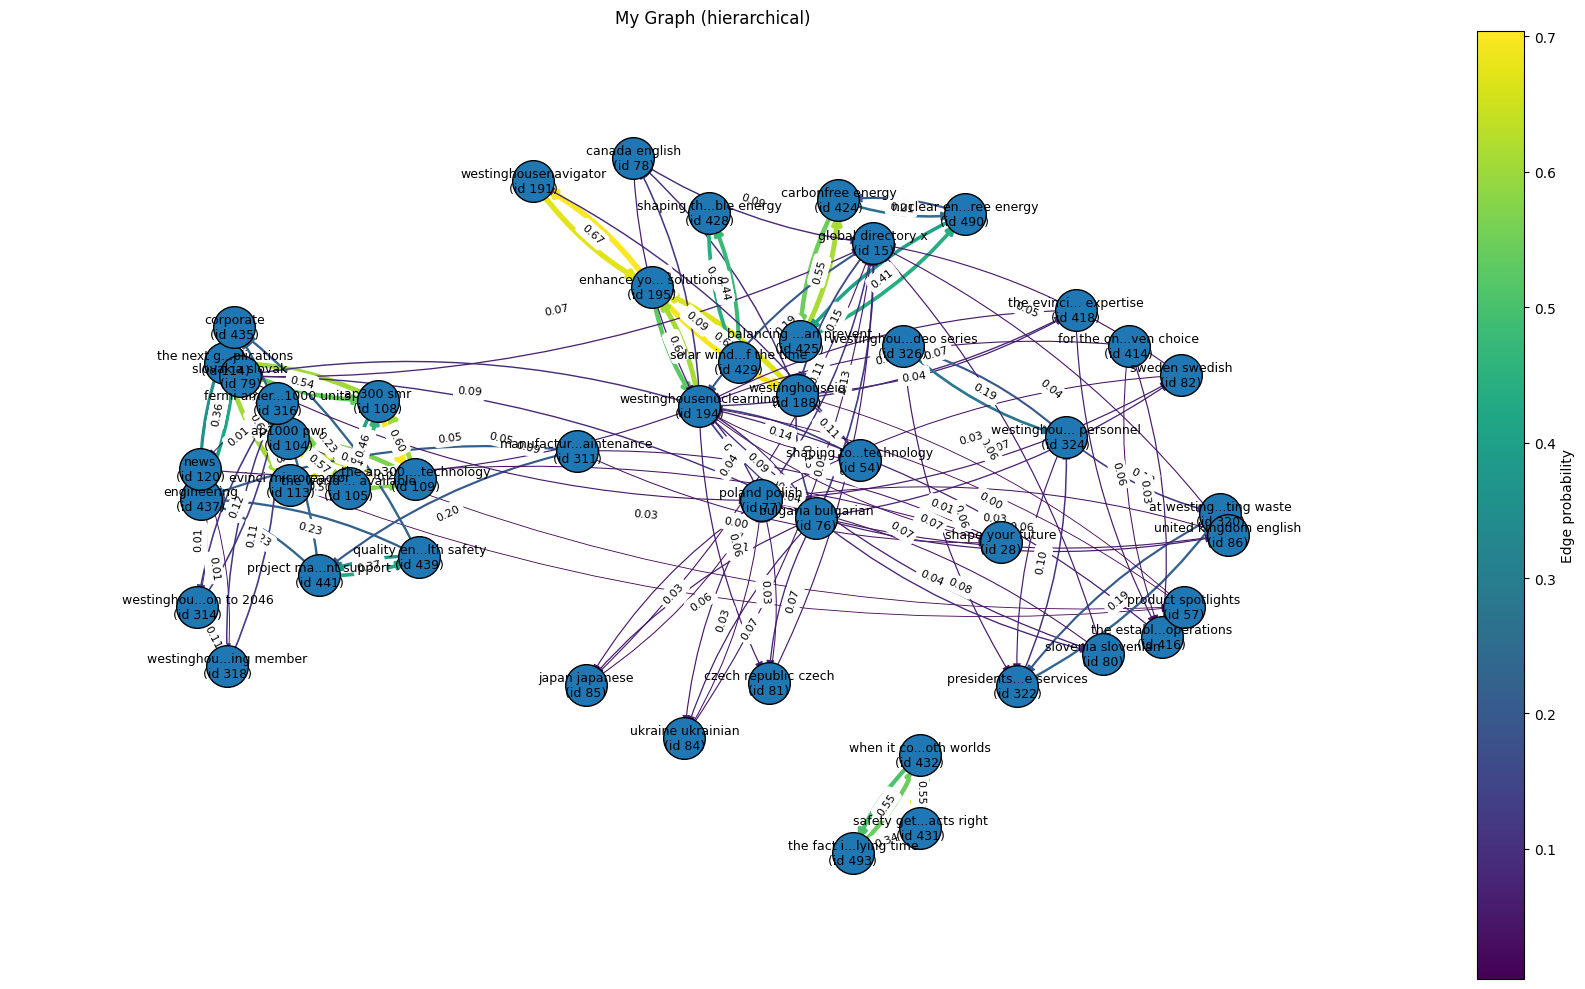

{'G': <networkx.classes.digraph.DiGraph at 0x703c8515f920>,
 'pos': {108: array([-0.56048609,  0.1835728 ]),
  109: array([-0.49508246, -0.02082513]),
  113: array([-0.71453286, -0.03771265]),
  114: array([-0.82762044,  0.28186834]),
  195: array([-0.08147725,  0.48099103]),
  191: array([-0.28891469,  0.75794091]),
  188: array([0.17278504, 0.1986179 ]),
  104: array([-0.71757082,  0.08481646]),
  105: array([-0.61154742, -0.04580941]),
  432: array([ 0.38762   , -0.74462305]),
  431: array([ 0.38901817, -0.93454509]),
  425: array([0.17796344, 0.33826725]),
  424: array([0.24543864, 0.70797316]),
  194: array([0.00221909, 0.16865943]),
  493: array([ 0.27071876, -1.        ]),
  429: array([0.07057248, 0.28358682]),
  428: array([0.01896775, 0.67462701]),
  490: array([0.46665975, 0.67195827]),
  441: array([-0.66378082, -0.27391655]),
  439: array([-0.48813969, -0.22508379]),
  437: array([-0.87104538, -0.07534299]),
  435: array([-0.81222574,  0.37673444]),
  326: array([0.3581483

In [10]:
# Display the graph
textmask = np.array([True]*len(txts))
#textmask = filterTextMask(txts, "%", False) #& mask = keepTopKMask(txts, 1)

numToShow=-1
for row in zip(sorted_label_index[textmask][:numToShow], xpaths[textmask][:numToShow], txts[textmask][:numToShow], probs[textmask][:numToShow]):
    print(row[2])
    # print("\t", row[3])
    # print("\t", row[0])
    # print("\t", row[1])

draw_graph_from_arrays(
    txt_edge_pairs=txts[textmask][:numToShow],
    id_edge_pairs=sorted_label_index[textmask][:numToShow],
    xpath_edge_pairs=xpaths[textmask][:numToShow],
    probs=probs[textmask][:numToShow],
    layout="spring",
    rankdir="TB",         # or "TB" for top→bottom
    layer_spacing=5.0,    # spread layers further
    node_spacing=2.5,     # spread nodes within a layer
    figsize=(16, 10),
    title="My Graph (hierarchical)",
)